In [72]:
from modules.models import FourierKawaharaPINN_noCInput, create_dense_model, create_dense_model_Normalized
from modules.data import simulate_seq2seqAmplitude
from modules.plots import plot_cParam_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML


In [103]:
n_samples = 21
dtype = tf.float32



k = np.arange(0,n_samples,1)
k = tf.reshape(tf.convert_to_tensor(k, dtype = dtype),(n_samples,1))



y_eqn = tf.zeros((n_samples, 1))
inputs = [k]
outputs = [y_eqn] 

In [154]:
normalizer = tf.keras.layers.Normalization(axis=None)
normalizer.adapt(k)
backbone = create_dense_model_Normalized([31, 31, 31, 31, 31, 31], activation = tf.math.cos, initializer='glorot_normal', \
    n_inputs=1, n_outputs=1, normalizer=normalizer)

In [155]:
pinn = FourierKawaharaPINN_noCInput(backbone, alpha = 1.0, beta= 1/26. ,sigma = 1., c=0.9657002576175904, loss_residual_weight=1.)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=400, decay_rate=0.86)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
pinn.compile(optimizer=optimizer)

In [156]:
# tf.config.run_functions_eagerly(True)
history = pinn.fit_custom(inputs, outputs, epochs=10000, print_every=500)
# pinn(inputs)

Epoch 0, Loss Residual: 9402449.0000
Epoch 500, Loss Residual: 19.9633
Epoch 1000, Loss Residual: 0.9027
Epoch 1500, Loss Residual: 0.0524
Epoch 2000, Loss Residual: 0.0348
Epoch 2500, Loss Residual: 0.0338
Epoch 3000, Loss Residual: 0.0331
Epoch 3500, Loss Residual: 0.0323
Epoch 4000, Loss Residual: 0.0314
Epoch 4500, Loss Residual: 0.0304
Epoch 5000, Loss Residual: 0.0294
Epoch 5500, Loss Residual: 0.0284
Epoch 6000, Loss Residual: 0.0273
Epoch 6500, Loss Residual: 0.0261
Epoch 7000, Loss Residual: 0.0249
Epoch 7500, Loss Residual: 0.0237
Epoch 8000, Loss Residual: 0.0224
Epoch 8500, Loss Residual: 0.0210
Epoch 9000, Loss Residual: 0.0197
Epoch 9500, Loss Residual: 0.0182


In [59]:
print(0.263524443**2, 0.23212868**2, 0.137268648**2)

0.06944513205846024 0.0538837240785424 0.018842681723747902


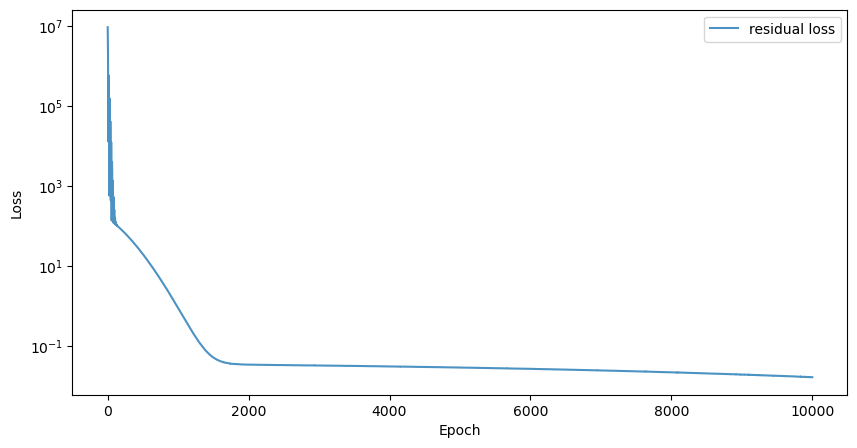

In [157]:
plot_training_loss(history, y_scale='log')



In [126]:

def plot_snapshots(model, cList, k_init, k_max, num_test_samples = 21):
    k_flat = np.linspace(k_init, k_max, num_test_samples)


    u = model.backbone.predict(k_flat, batch_size=num_test_samples)
    plt.plot(k_flat, tf.abs(u),'.')
    plt.show()
    plt.xlabel('k')
    plt.ylabel('u(c,k)')
    plt.semilogy(k_flat, tf.abs(u),'.')
    # plt.legend()
    return u

In [127]:
c0 = 0.9615

1/1 [==============================] - 0s 18ms/step


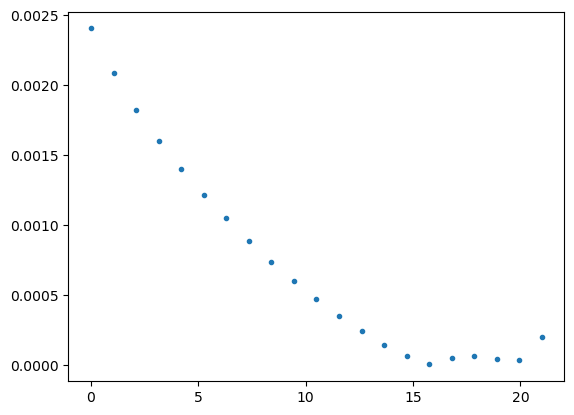

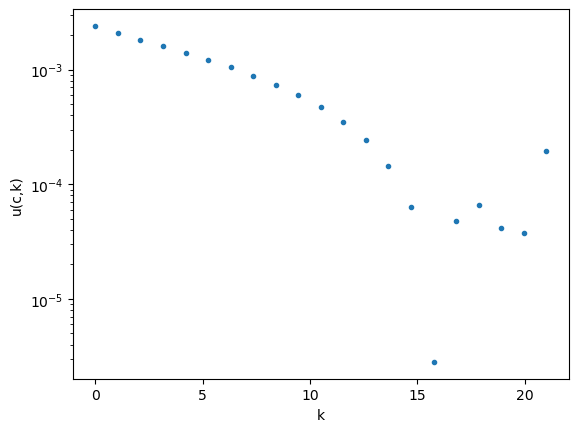

In [158]:
u = plot_snapshots(pinn, [ 0.9657002576175904], 0, 21, num_test_samples = 21)

In [169]:
x = np.linspace(0,2*np.pi, 201)
cos = 0
for ind, val in enumerate(u[0:18]):
    cos+= val*np.cos(ind*x)
    

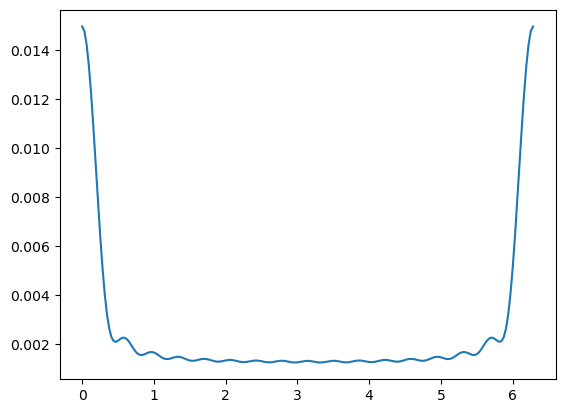

In [170]:
plt.plot(x,-cos)

In [147]:
def kawaharainitial(U, a1, alpha, beta, sigma, N): #defining the equation
    kawaharaCosEqnsPos=np.zeros(N+2,dtype='float64') #first set all the equations equal to 0=0
    
    
    V=U[0] #Vector U contains the unknown coefficients and the unknown speed, we have N+2 unknowns
    a=U[1::]
    
    ### for the coefficients ###
    
    for k in range(N+1):
        sum1=0.#set the sums for the nonlinear term equal to 0 when solving for every coefficient
        sum2=0.
        for n in range(k,N+1):
            sum1=sum1+a[n]*a[n-k] 
        for n in range(0,k):
            sum2=sum2+a[n]*a[k-n] 
        kawaharaCosEqnsPos[k]=((V*a[k] + 1./2.*sigma*sum1 + 1./2.*sigma*sum2 - alpha*k**2*a[k] + beta*k**4*a[k]))
        
        
    kawaharaCosEqnsPos[N+1]=-a1+a[1] 
    return kawaharaCosEqnsPos
             
    
    

In [145]:
speed = np.zeros((1,1))
speed[0,0 ]= 0.9657002576175904
u_sol = np.concatenate((speed,u), axis=0)
print(u_sol)

[[ 9.65700258e-01]
 [ 7.50907348e-05]
 [ 1.13519607e-04]
 [ 1.21534162e-04]
 [ 1.13760703e-04]
 [ 1.01284357e-04]
 [ 9.26587381e-05]
 [ 9.00926534e-05]
 [ 9.07513895e-05]
 [ 9.10906820e-05]
 [ 8.55365652e-05]
 [ 7.17184739e-05]
 [ 4.98309382e-05]
 [ 2.45638075e-05]
 [ 1.32620335e-06]
 [-1.41821802e-05]
 [-1.76515896e-05]
 [-9.77423042e-06]
 [ 3.01987166e-06]
 [ 9.56765143e-06]
 [-4.70818486e-06]
 [-5.36969746e-05]]


In [149]:
kawaharainitial(u_sol, u_sol[2], 1., 1/36., 1., 20)

array([ 7.25695890e-05, -6.85502765e-07, -3.14699832e-04, -6.57968613e-04,
       -8.02436851e-04, -6.18271005e-04,  8.70600406e-05,  1.69349044e-03,
        4.62231294e-03,  8.74323304e-03,  1.28192602e-02,  1.42845915e-02,
        1.06353294e-02,  8.29348407e-04, -1.23679188e-02, -2.08679612e-02,
       -1.53006605e-02,  6.13637327e-03,  2.48086019e-02, -1.53486451e-02,
       -2.17226284e-01,  0.00000000e+00])